In [1]:
#MODEL 3-----------------------------------source venv/bin/activate

In [2]:
import torch
import torch.nn as nn
from torchvision import models
from torchsummary import summary

import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt


import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Shallow ResNet50

from torchvision.models import resnet50

class ShallowResNet50(nn.Module):
    def __init__(self, num_classes=7):  # Updated for 7 classes
        super(ShallowResNet50, self).__init__()
        base_model = resnet50(weights=None)  # Using untrained ResNet-50

        # Stem layers: initial conv + BN + ReLU + MaxPool
        self.stem = nn.Sequential(
            base_model.conv1,
            base_model.bn1,
            base_model.relu,
            base_model.maxpool
        )

        # Reduced residual blocks
        self.layer1 = base_model.layer1              # Keep all 3 blocks
        self.layer2 = base_model.layer2[:2]          # First 2 of 4 blocks
        self.layer3 = base_model.layer3[:2]          # First 2 of 6 blocks
        self.layer4 = base_model.layer4[:1]          # First of 3 blocks

        # Pooling and FC layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(2048, num_classes)  # Final output layer for 7 classes
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    
# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ShallowResNet50(num_classes=7).to(device)

# Show model summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [4]:
# Print Model Architecture
if __name__ == "__main__":
    model = ShallowResNet50(num_classes=7)
    print(model)

ShallowResNet50(
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, ker

In [5]:
#TRAIN

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
train_dir = "augmented_train"               
val_csv = "val_split_BeoShock.csv"


# Hyperparameters
num_classes = 7
batch_size = 32 #original ResNet50 batchsize=256
epochs = 50
learning_rate = 0.01
momentum = 0.9
weight_decay = 0.001 #original weight decay 0.00001


# image transformation
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# Load training data using folder structure
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Load validation data using CSV file
class ValidationDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.label_map = {label: idx for idx, label in enumerate(sorted(self.data['label'].unique()))}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['image_path']
        label = self.label_map[self.data.iloc[idx]['label']]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

val_dataset = ValidationDataset(csv_file=val_csv, transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model and training components
model = ShallowResNet50(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,
                            momentum=momentum, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


# Training loop
for epoch in range(epochs):
    model.train()
    train_loss, train_correct, total_train = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    scheduler.step()

    train_losses.append(train_loss / len(train_loader.dataset))
    train_accuracies.append(100 * train_correct / total_train)

    # Validation
    model.eval()
    val_loss, val_correct, total_val = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader.dataset))
    val_accuracies.append(100 * val_correct / total_val)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}% | "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

# Save model
torch.save(model.state_dict(), "model3_shallow_resnet50_trained.pth")
print("Training complete!")

Epoch [1/50] Train Loss: 1.7874, Train Acc: 32.44% | Val Loss: 1.6158, Val Acc: 32.66%
Epoch [2/50] Train Loss: 1.4153, Train Acc: 44.21% | Val Loss: 1.3854, Val Acc: 45.97%
Epoch [3/50] Train Loss: 1.0627, Train Acc: 58.53% | Val Loss: 1.1358, Val Acc: 58.27%
Epoch [4/50] Train Loss: 0.8469, Train Acc: 67.51% | Val Loss: 1.2428, Val Acc: 57.86%
Epoch [5/50] Train Loss: 0.7317, Train Acc: 72.20% | Val Loss: 1.1086, Val Acc: 60.69%
Epoch [6/50] Train Loss: 0.6495, Train Acc: 74.94% | Val Loss: 1.2240, Val Acc: 59.48%
Epoch [8/50] Train Loss: 0.5320, Train Acc: 79.77% | Val Loss: 1.0017, Val Acc: 65.93%
Epoch [9/50] Train Loss: 0.4756, Train Acc: 82.14% | Val Loss: 0.9962, Val Acc: 67.34%
Epoch [10/50] Train Loss: 0.4346, Train Acc: 83.49% | Val Loss: 1.3448, Val Acc: 59.48%
Epoch [11/50] Train Loss: 0.3971, Train Acc: 85.01% | Val Loss: 1.5913, Val Acc: 61.90%
Epoch [12/50] Train Loss: 0.3640, Train Acc: 86.50% | Val Loss: 1.0256, Val Acc: 67.54%
Epoch [13/50] Train Loss: 0.3361, Train 

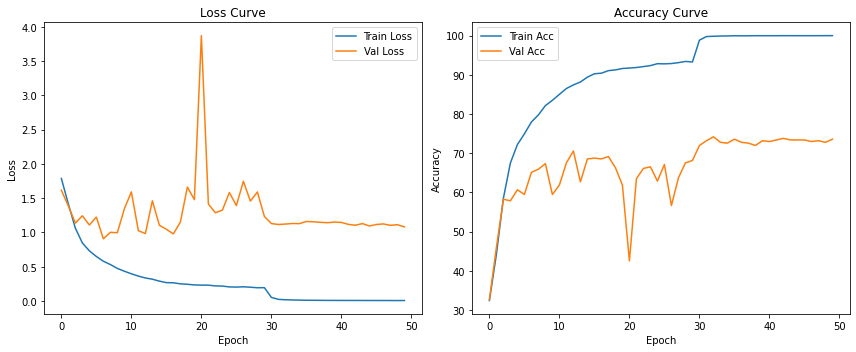

In [7]:
# Plot curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
#Original Hyperparameter ResNet 50 for Training ImageNet-----------

#Optimizer	SGD (Stochastic Gradient Descent)
#Learning Rate	0.1 (reduced by 10x at specific epochs)
#Momentum	0.9
#Weight Decay	1e-4 (to regularize and prevent overfitting)
#Batch Size	256 (distributed across multiple GPUs)
#Number of Epochs	90
#Learning Rate Scheduler	Step decay (every 30 epochs)
#Initialization	He initialization
#Input Image Size	224×224

In [9]:
#Testing

             Metric     Value
0  Top-1 Error Rate  0.272177
1  Top-3 Error Rate  0.042339
2  Top-5 Error Rate  0.010081
3          Accuracy  0.727823
4          F1 Score  0.724432
5         AUC Score  0.891875


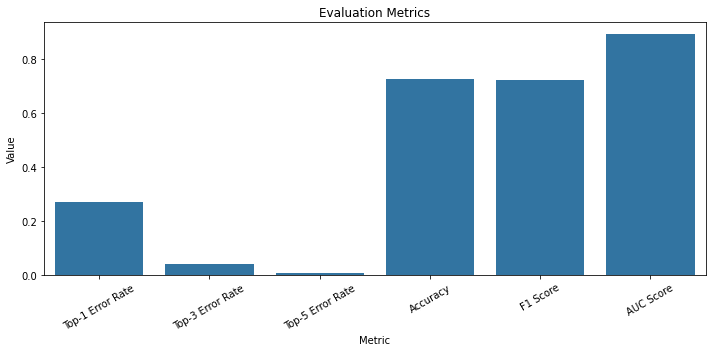

In [10]:
# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
csv_file = 'test_split_BeoShock.csv'
num_classes = 7
batch_size = 32

# Define label mapping for AUC score
non_cancerous = ['NE_Follicular', 'NE_Luteal', 'NE_Menstrual']
cancerous = ['EA', 'EP', 'EH_Simple', 'EH_Complex']
all_labels = cancerous + non_cancerous
label_to_idx = {label: idx for idx, label in enumerate(sorted(all_labels))}
binary_map = {label_to_idx[lbl]: 0 if lbl in non_cancerous else 1 for lbl in all_labels}

# Image transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Transform Test Dataset
class TestDataset(Dataset):
    def __init__(self, csv_file, transform):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.label_map = label_to_idx

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['image_path']
        label = self.label_map[self.data.iloc[idx]['label']]
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.data)

# Load model
model = ShallowResNet50(num_classes=num_classes).to(device)
model.load_state_dict(torch.load('model3_shallow_resnet50_trained.pth', map_location=device))
model.eval()

# Load data
dataset = TestDataset(csv_file, transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Inference
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in loader:
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1).cpu().numpy()
        all_probs.append(probs)
        all_labels.extend(labels.numpy())

all_probs = np.concatenate(all_probs)
all_labels = np.array(all_labels)

# Metrics
top1_preds = np.argmax(all_probs, axis=1)
top1_error = 1 - np.mean(top1_preds == all_labels)

top3_preds = np.argsort(all_probs, axis=1)[:, -3:]
top3_error = 1 - np.mean([label in top3 for label, top3 in zip(all_labels, top3_preds)])

top5_preds = np.argsort(all_probs, axis=1)[:, -5:]
top5_error = 1 - np.mean([label in top5 for label, top5 in zip(all_labels, top5_preds)])

accuracy = accuracy_score(all_labels, top1_preds)

f1 = f1_score(all_labels, top1_preds, average='weighted')

# Binary labels for AUC
binary_labels = np.array([binary_map[lbl] for lbl in all_labels])
cancer_indices = [label_to_idx[lbl] for lbl in cancerous]
binary_probs = all_probs[:, cancer_indices].sum(axis=1)
auc = roc_auc_score(binary_labels, binary_probs)

# Results
metrics = {
    "Top-1 Error Rate": top1_error,
    "Top-3 Error Rate": top3_error,
    "Top-5 Error Rate": top5_error,
    "Accuracy": accuracy,
    "F1 Score": f1,
    "AUC Score": auc
}

# Plot
df = pd.DataFrame(metrics.items(), columns=["Metric", "Value"])
print(df)

plt.figure(figsize=(10, 5))
sns.barplot(data=df, x="Metric", y="Value")
plt.xticks(rotation=30)
plt.title("Evaluation Metrics")
plt.tight_layout()
plt.show()

In [ ]:
#Variant          | Residual Blocks | Conv Layers in Blocks | Total Conv Layers
#Original ResNet-50    | 16 |                48                     | 49
#Custom (Shallow)       | 8 |                24                     | 25